# **Face Mask Detection Model:**

### **Importing Libraries:**

In [2]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import files
import tensorflow as tf
import numpy as np
from PIL import Image
import os
import cv2
import random
import shutil

### **Downloading the dataset:**

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vijaykumar1799/face-mask-detection")

print("Path to dataset files:", path)

100%|██████████| 222M/222M [00:10<00:00, 21.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vijaykumar1799/face-mask-detection/versions/1


### **Preparing dataset:**

In [4]:
for cls in ["with_mask", "without_mask", "mask_weared_incorrect"]:
  os.makedirs(os.path.join("FaceMaskDataset", cls), exist_ok=True)

In [5]:
for cls in ["with_mask", "without_mask", "mask_weared_incorrect"]:
  src_dir = os.path.join(path,"Dataset" ,cls)
  dst_dir = os.path.join("FaceMaskDataset", cls)
  for img in os.listdir(src_dir):
    shutil.copy(os.path.join(src_dir, img), os.path.join(dst_dir, f"vijay_{img}"))


In [6]:
for folder in os.listdir("FaceMaskDataset"):
    folder_path = os.path.join("FaceMaskDataset", folder)
    print(f"{folder}: {len(os.listdir(folder_path))} images")

without_mask: 2994 images
mask_weared_incorrect: 2994 images
with_mask: 2994 images


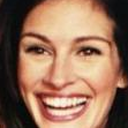

Cropped image class: without_mask


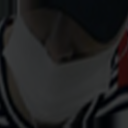

Cropped image class: mask_weared_incorrect


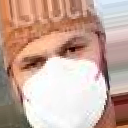

Cropped image class: with_mask


In [7]:
#Random image from each class:
for folder in os.listdir("FaceMaskDataset"):
    image_path = os.path.join("FaceMaskDataset", folder)
    images=random.choice(os.listdir(image_path))
    image = cv2.imread(os.path.join("FaceMaskDataset", folder,images))
    if image is not None:
      cv2_imshow(image)
      print(f"Cropped image class: {folder}")

### **Split dataset to train/val/test sets:**

In [8]:
output_dir = "DatasetSplit"
splits=["train","val","test"]
for split in splits:
    for cls in ["mask_weared_incorrect","with_mask","without_mask"]:
        os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

for label in os.listdir("FaceMaskDataset"):
    images = os.listdir(os.path.join("FaceMaskDataset", label))
    random.shuffle(images)
    train_images = images[:int(0.7 * len(images))]
    val_images = images[int(0.7 * len(images)):int(0.90 * len(images))]
    test_images = images[int(0.90 * len(images)):]
    for img in train_images:
        src=os.path.join("FaceMaskDataset", label, img)
        dst=os.path.join(output_dir, "train", label, img)
        shutil.copyfile(src, dst)
    for img in val_images:
        src=os.path.join("FaceMaskDataset", label, img)
        dst=os.path.join(output_dir, "val", label, img)
        shutil.copyfile(src, dst)
    for img in test_images:
        src=os.path.join("FaceMaskDataset", label, img)
        dst=os.path.join(output_dir, "test", label, img)
        shutil.copyfile(src, dst)

### **Load and prepare image datasets:**

In [9]:
train_data=tf.keras.utils.image_dataset_from_directory(
    "/content/DatasetSplit/train",
    batch_size=32,
    image_size=(128,128),
    label_mode="categorical",
    seed=42
)
val_data=tf.keras.utils.image_dataset_from_directory(
    "/content/DatasetSplit/val",
    batch_size=32,
    image_size=(128,128),
    label_mode="categorical",
    seed=42
)
test_data=tf.keras.utils.image_dataset_from_directory(
    "/content/DatasetSplit/test",
    batch_size=32,
    image_size=(128,128),
    label_mode="categorical",
    seed=42
)
class_names=train_data.class_names

Found 6285 files belonging to 3 classes.
Found 1797 files belonging to 3 classes.
Found 900 files belonging to 3 classes.


In [10]:
train_data=train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data=val_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_data=test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### **Model building:**

In [11]:
# Data augmentation layer
aug_layers=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128,128,3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

model = tf.keras.models.Sequential([
    aug_layers,
    tf.keras.layers.Rescaling(1./255),# Scaling images
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),# 1st Convolutional layer
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),# 2nd Convolutional layer
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),# 3rd Convolutional layer
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),# 4th Convolutional layer
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')

])

In [12]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,749,763 (10.49 MB)

 Trainable params: 2,749,251 (10.49 MB)

 Non-trainable params: 512 (2.00 KB)

In [13]:
model.compile(optimizer="adam",  loss="categorical_crossentropy", metrics=["accuracy"])

In [14]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop after 5 epochs with no improvement
    restore_best_weights=True
)

In [15]:
lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

### **Train the model:**

In [16]:
history = model.fit(train_data, epochs=15, validation_data=val_data, verbose=1,callbacks=[[lr_schedule],[early_stop]])

Epoch 1/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.8059 - loss: 0.5458 - val_accuracy: 0.7051 - val_loss: 1.0076 - learning_rate: 0.0010
Epoch 2/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8645 - loss: 0.3484 - val_accuracy: 0.8292 - val_loss: 0.4242 - learning_rate: 0.0010
Epoch 3/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8868 - loss: 0.3065 - val_accuracy: 0.8141 - val_loss: 0.5841 - learning_rate: 0.0010
Epoch 4/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8878 - loss: 0.2993
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8878 - loss: 0.2992 - val_accuracy: 0.7518 - val_loss: 0.6732 - learning_rate: 0.0010
Epoch 5/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9107 - loss: 0.2369 - val_accuracy: 0.9388 - val_loss: 0.1884 - learning_rate: 5.0000e-04
Epoch 6/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9209 - loss

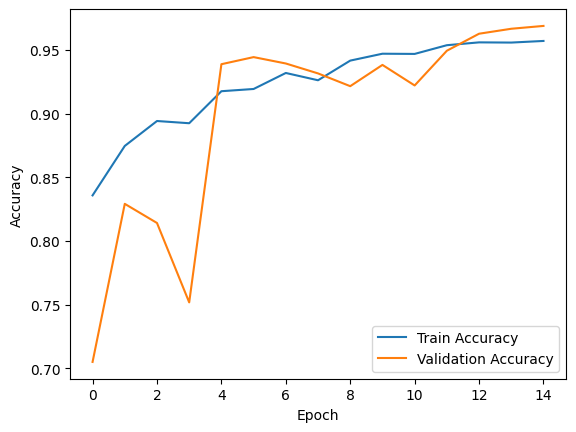

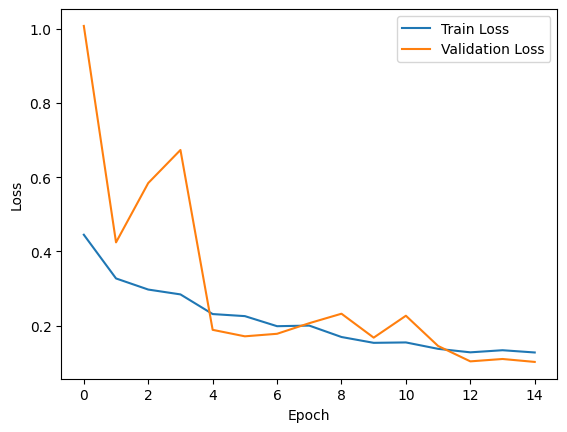

In [17]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### **Test the model:**

In [18]:
test_loss,test_acc=model.evaluate(test_data)
print(f'Test Accuracy: {round(test_acc,3)} Loss Acuuracy:{round(test_loss,3)}')

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9777 - loss: 0.0855
Test Accuracy: 0.973 Loss Acuuracy:0.091


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━

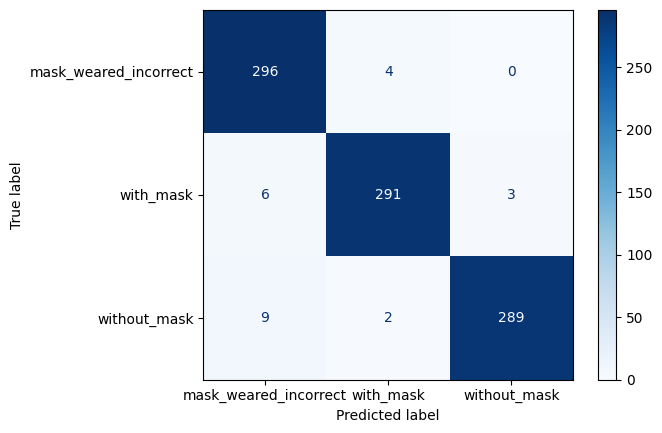

In [19]:
y_true = []
y_pred = []

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap="Blues")

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


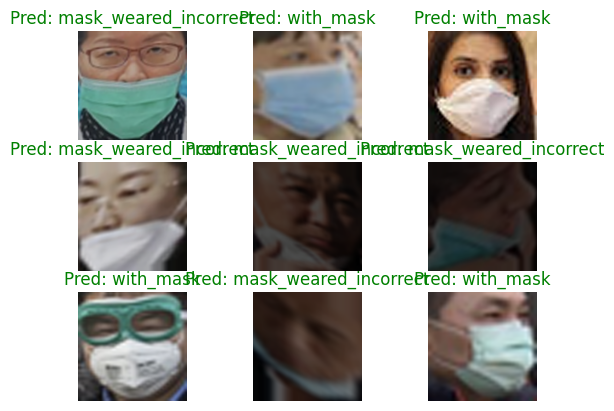

In [20]:
for images, labels in test_data.take(1):
    preds = model.predict(images)
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred_class = np.argmax(preds[i])
        true_class = np.argmax(labels[i])  # if label_mode='categorical'
        color = "green" if pred_class == true_class else "red"
        plt.title(f"Pred: {class_names[pred_class]}", color=color)
        plt.axis("off")
    plt.show()


In [21]:
# Load Haar cascade face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Upload and process image
uploaded = files.upload()

for fn in uploaded.keys():
    # Load image using OpenCV
    img_cv = cv2.imread(fn)
    gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    if len(faces) == 0:
        print("❌ No face detected in the image.")
        continue

    # Crop the first detected face
    for (x, y, w, h) in faces:
      margin = 20
      x = max(0, x - margin)
      y = max(0, y - margin)
      w = min(img_cv.shape[1] - x, w + 2*margin)
      h = min(img_cv.shape[0] - y, h + 2*margin)
      face_img = img_cv[y:y+h, x:x+w]
      break

    # Convert to RGB and PIL format for model input
    face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    face_img = Image.fromarray(face_img)
    face_img = face_img.resize((128, 128))  # Match your model input size

    # Prepare for prediction
    img_array = np.array(face_img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class_name = class_names[predicted_class_index]

    # Show result
    plt.imshow(face_img)
    plt.title(f"Prediction: {predicted_class_name}")
    plt.axis("off")
    plt.show()
